# RNN PyTorch 实现

In [101]:
import os
import re
import math
import random
import collections
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from d2l import torch as d2l

## 1. 构建训练集

### 1.1 加载数据

In [102]:
# 加载文本数据
fp = os.path.abspath("./data/jaychou_lyrics.txt")
tokens = [char for char in " ".join(open(fp, "r").readlines()).replace("\n", "")]
print(tokens[:100])

['想', '要', '有', '直', '升', '机', ' ', '想', '要', '和', '你', '飞', '到', '宇', '宙', '去', ' ', '想', '要', '和', '你', '融', '化', '在', '一', '起', ' ', '融', '化', '在', '宇', '宙', '里', ' ', '我', '每', '天', '每', '天', '每', '天', '在', '想', '想', '想', '想', '著', '你', ' ', '这', '样', '的', '甜', '蜜', ' ', '让', '我', '开', '始', '乡', '相', '信', '命', '运', ' ', '感', '谢', '地', '心', '引', '力', ' ', '让', '我', '碰', '到', '你', ' ', '漂', '亮', '的', '让', '我', '面', '红', '的', '可', '爱', '女', '人', ' ', '温', '柔', '的', '让', '我', '心', '疼', '的', '可']


### 1.2 中文分词

In [103]:
class Vocab:  
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens): 
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [104]:
vocab = Vocab(tokens)

In [105]:
len(vocab)

2583

### 1.3 构建训练集

In [106]:
class SeqDataLoader: 
    """加载序列数据的迭代器"""
    def __init__(self, tokens, batch_size, num_steps, use_random_iter=True, max_tokens=-1):
        if use_random_iter:
            self.data_iter_fn = self.seq_data_iter_random
        else:
            self.data_iter_fn = self.seq_data_iter_sequential
        self.vocab = Vocab(tokens, min_freq=5)
        self.corpus = [self.vocab[token] for token in tokens]
        if max_tokens > 0:
            self.corpus = self.corpus[:max_tokens]
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)
    
    def seq_data_iter_sequential(self, corpus, batch_size, num_steps):  #@save
        """使用顺序分区生成一个小批量子序列"""
        # 从随机偏移量开始划分序列
        offset = random.randint(0, num_steps)
        num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
        Xs = torch.tensor(corpus[offset: offset + num_tokens])
        Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
        Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
        num_batches = Xs.shape[1] // num_steps
        for i in range(0, num_steps * num_batches, num_steps):
            X = Xs[:, i: i + num_steps]
            Y = Ys[:, i: i + num_steps]
            yield X, Y

    def seq_data_iter_random(self, corpus, batch_size, num_steps):  #@save
        """使用随机抽样生成一个小批量子序列"""
        # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
        corpus = corpus[random.randint(0, num_steps - 1):]
        # 减去1，是因为我们需要考虑标签
        num_subseqs = (len(corpus) - 1) // num_steps
        # 长度为num_steps的子序列的起始索引
        initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
        # 在随机抽样的迭代过程中，
        # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
        random.shuffle(initial_indices)

        def data(pos):
            # 返回从pos位置开始的长度为num_steps的序列
            return corpus[pos: pos + num_steps]

        num_batches = num_subseqs // batch_size
        for i in range(0, batch_size * num_batches, batch_size):
            # 在这里，initial_indices包含子序列的随机起始索引
            initial_indices_per_batch = initial_indices[i: i + batch_size]
            X = [data(j) for j in initial_indices_per_batch]
            Y = [data(j + 1) for j in initial_indices_per_batch]
            yield torch.tensor(X), torch.tensor(Y)

In [107]:
seq_data_iter = SeqDataLoader(tokens, 3, 10, False)

In [108]:
len(seq_data_iter.vocab)

1433

In [109]:
seq_data_iter.num_steps, seq_data_iter.batch_size

(10, 3)

In [110]:
for i, (X, Y) in enumerate(seq_data_iter):
    if i > 2:
        break
    print(X.shape, Y.shape)
    print(f"X:")
    for x in X:
        print(seq_data_iter.vocab.to_tokens(x.tolist()))
    print("Y:")
    for y in Y:
        print(seq_data_iter.vocab.to_tokens(y.tolist()))

torch.Size([3, 10]) torch.Size([3, 10])
X:
['想', '要', '有', '直', '升', '机', ' ', '想', '要', '和']
['书', '框', '的', '城', '堡', '\u3000', '像', '欧', '<unk>', '情']
[' ', '会', '有', '两', '块', '空', '地', '那', '就', '是']
Y:
['要', '有', '直', '升', '机', ' ', '想', '要', '和', '你']
['框', '的', '城', '堡', '\u3000', '像', '欧', '<unk>', '情', '调']
['会', '有', '两', '块', '空', '地', '那', '就', '是', '勇']
torch.Size([3, 10]) torch.Size([3, 10])
X:
['你', '飞', '到', '宇', '宙', '去', ' ', '想', '要', '和']
['调', ' ', '书', '框', '的', '城', '堡', '\u3000', '像', '欧']
['勇', '气', '与', '<unk>', '力', ' ', '我', '要', '做', '音']
Y:
['飞', '到', '宇', '宙', '去', ' ', '想', '要', '和', '你']
[' ', '书', '框', '的', '城', '堡', '\u3000', '像', '欧', '<unk>']
['气', '与', '<unk>', '力', ' ', '我', '要', '做', '音', '乐']
torch.Size([3, 10]) torch.Size([3, 10])
X:
['你', '融', '化', '在', '一', '起', ' ', '融', '化', '在']
['<unk>', '情', '调', ' ', '对', '着', '这', '张', '海', '报']
['乐', '上', '的', '<unk>', '<unk>', ' ', '哼', '哼', '哈', '兮']
Y:
['融', '化', '在', '一', '起', ' ', '融', '化', '在',

## 2.模型构建

In [111]:
class RNNModel(nn.Module):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer    # RNN层
        self.vocab_size = vocab_size    # 分词词库大小
        self.num_hiddens = self.rnn.hidden_size     # 隐藏层的节点数
        if not self.rnn.bidirectional:  # 如果是双向
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)  # 线性层 /输出层
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
    
    def forward(self, inputs, state):
        """
        前向传播
        :params: inputs: 输入
        :params: state: 隐藏状态
        """
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state
    
    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return torch.zeros((self.num_directions * self.rnn.num_layers, 
                                batch_size, self.num_hiddens),
                                device = device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                     torch.zeros((
                         self.num_directions * self.rnn.num_layers,
                         batch_size, self.num_hiddens), device=device))#(h_n, c_n)

## 3. 模型训练函数

In [112]:
def predict_ch8(prefix, num_preds, net, vocab, device):
    """在`prefix`后面生成新字符"""
    #生成初始隐藏状态
    state = net.begin_state(batch_size=1, device=device) 
    outputs = [vocab[prefix[0]]] #第一个word的整型下标
    #将最近预测的词做成tensor, batch_size=1, n_step=1
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]: # 预热操作, 保存真值
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds): # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [113]:
def grad_clipping(net, theta):
    """裁剪梯度"""
    if isinstance(net, nn.Module):#如果使用nn.Module来实现
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum(
        (p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [114]:
def train_epoch_ch8(net, train_iter, loss, updater, device,
                   use_random_iter):
    """训练模型一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)
    for X, Y in train_iter:
        if state is None or use_random_iter:#为第一个batch 或者 batch之间时序上不连续
            state = net.begin_state(batch_size=X.shape[0], device=device) #初始化state
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_() # 对之前的部分取消梯度反向传播计算
            else:
                # state对于nn.LSTM或者对于我们从零开始实现的模型是个元组(张量构成)
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1) #reshape真值, 将n_step放在第一维之后拉成一维向量
        X, y = X.to(device), y.to(device)
        y_hat,state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):#调用torch优化函数实现
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [ ]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                           legend=['train'], xlim=[10,num_epochs])
    #初始化优化器
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    #训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('吹完它就走'))
            animator.add(epoch+1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('吹完它就走'))
    # print(predict('我想要'))

In [116]:
batch_size = 5
num_steps = 10
num_hiddens = 512
state = torch.zeros((1, batch_size, num_hiddens))
state.shape #(D * num_layers(=1), batch_size, num_hiddens) 

torch.Size([1, 5, 512])

In [117]:
rnn_layer = nn.RNN(input_size=len(vocab), hidden_size=512)

In [118]:
seq_data_iter = SeqDataLoader(tokens, batch_size, num_steps, False)

In [119]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
predict_ch8('想要有', 10, net, vocab, device)

'想要有冒膏柔阶丧膏膏膏膏膏'

KeyboardInterrupt: 

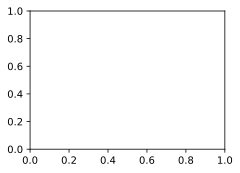

In [123]:
num_epochs, lr = 500, 1
train_ch8(net, seq_data_iter, vocab, lr, num_epochs, device, use_random_iter=True)